<a href="https://colab.research.google.com/github/ihyaulumuddin044/machineLearning/blob/main/Prediksi_Harga_emas(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Long Short-Term Memory (LSTM) dalam Prediksi Harga Emas
LSTM (Long Short-Term Memory) adalah jenis Recurrent Neural Network (RNN) yang dirancang untuk mengatasi masalah long-term dependencies dalam data sekuensial seperti time series. LSTM sangat cocok untuk prediksi harga emas karena harga emas bersifat waktu ke waktu dan dipengaruhi oleh tren historis.

#1: import library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

#2: lihat datanya

In [ ]:
df = pd.read_csv('emas_IDR.csv')
df

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,31/12/2024,1.357.613,1.357.088,1.373.975,1.350.113,NaN,"0,03%"
1,30/12/2024,1.357.210,1.369.228,1.370.851,1.351.717,NaN,"-0,54%"
2,27/12/2024,1.364.551,1.370.732,1.380.258,1.359.523,NaN,"-0,46%"
3,26/12/2024,1.370.866,1.363.425,1.374.878,1.363.425,NaN,"0,57%"
4,25/12/2024,1.363.059,1.360.593,1.363.829,1.360.593,NaN,"0,18%"
...,...,...,...,...,...,...,...
1254,23/09/2020,883.681,905.655,906.385,883.315,NaN,"-2,38%"
1255,22/09/2020,905.271,905.564,911.333,901.463,NaN,"-0,09%"
1256,21/09/2020,906.079,923.118,926.375,891.055,NaN,"-1,83%"
1257,20/09/2020,923.015,923.929,924.312,922.323,NaN,"-0,10%"


In [ ]:
# informasi data yang kita miliki
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tanggal     1259 non-null   object 
 1   Terakhir    1259 non-null   object 
 2   Pembukaan   1259 non-null   object 
 3   Tertinggi   1259 non-null   object 
 4   Terendah    1259 non-null   object 
 5   Vol.        0 non-null      float64
 6   Perubahan%  1259 non-null   object 
dtypes: float64(1), object(6)
memory usage: 69.0+ KB


#3: Mempersiapkan data

menghapus data yang tidak digunaka

In [ ]:
df.drop(['Vol.', 'Perubahan%'], axis=1, inplace=True)
df.head()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah
0,31/12/2024,1.357.613,1.357.088,1.373.975,1.350.113
1,30/12/2024,1.357.210,1.369.228,1.370.851,1.351.717
2,27/12/2024,1.364.551,1.370.732,1.380.258,1.359.523
3,26/12/2024,1.370.866,1.363.425,1.374.878,1.363.425
4,25/12/2024,1.363.059,1.360.593,1.363.829,1.360.593


##**3.1:** mengubah tanggal ke yang berupa objek menjadi type dateTime

In [ ]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df.sort_values(by='Tanggal', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()


<ipython-input-233-41a90b51805e>:1: UserWarning:

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah
0,2020-09-18,923.929,928.437,932.318,921.777
1,2020-09-20,923.015,923.929,924.312,922.323
2,2020-09-21,906.079,923.118,926.375,891.055
3,2020-09-22,905.271,905.564,911.333,901.463
4,2020-09-23,883.681,905.655,906.385,883.315


In [ ]:
df.head()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah
0,2020-09-18,923.929,928.437,932.318,921.777
1,2020-09-20,923.015,923.929,924.312,922.323
2,2020-09-21,906.079,923.118,926.375,891.055
3,2020-09-22,905.271,905.564,911.333,901.463
4,2020-09-23,883.681,905.655,906.385,883.315


In [ ]:
NumCols = df.columns.drop(['Tanggal'])  # Ambil semua kolom kecuali 'Tanggal'

# Ganti titik pemisah ribuan dan string kosong dengan '0'
df[NumCols] = df[NumCols].replace({'\.': ''}, regex=True)

# Ubah tipe data ke float
df[NumCols] = df[NumCols].astype('float64')

# Ubah format tanggal menjadi datetime
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')

print(df.dtypes)  # Cek tipe data setelah konversi
print(df.head())  # Lihat hasil data

Tanggal      datetime64[ns]
Terakhir            float64
Pembukaan           float64
Tertinggi           float64
Terendah            float64
dtype: object
     Tanggal  Terakhir  Pembukaan  Tertinggi  Terendah
0 2020-09-18  923929.0   928437.0   932318.0  921777.0
1 2020-09-20  923015.0   923929.0   924312.0  922323.0
2 2020-09-21  906079.0   923118.0   926375.0  891055.0
3 2020-09-22  905271.0   905564.0   911333.0  901463.0
4 2020-09-23  883681.0   905655.0   906385.0  883315.0


In [ ]:
df.head()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah
0,2020-09-18,923929.0,928437.0,932318.0,921777.0
1,2020-09-20,923015.0,923929.0,924312.0,922323.0
2,2020-09-21,906079.0,923118.0,926375.0,891055.0
3,2020-09-22,905271.0,905564.0,911333.0,901463.0
4,2020-09-23,883681.0,905655.0,906385.0,883315.0


##3.2 mencari data duplikat

In [ ]:
# duplikat
df.duplicated().sum()

0

##3.3 melihat data yang hilang

In [ ]:
# data hilang
df.isnull().sum().sum()

0

# 4: Visulisasi data emas

In [ ]:
fig = px.line(y=df.Terakhir, x=df.Tanggal)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="tanggal",
                  yaxis_title="harga_terakhir(IDR)",
                  title={'text': "histori pergerakan harga emas", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  )

#5: Membagi data menjadi data pelatihan data testing

In [ ]:
test_size = df[df.Tanggal.dt.year==2024].shape[0]
test_size

262

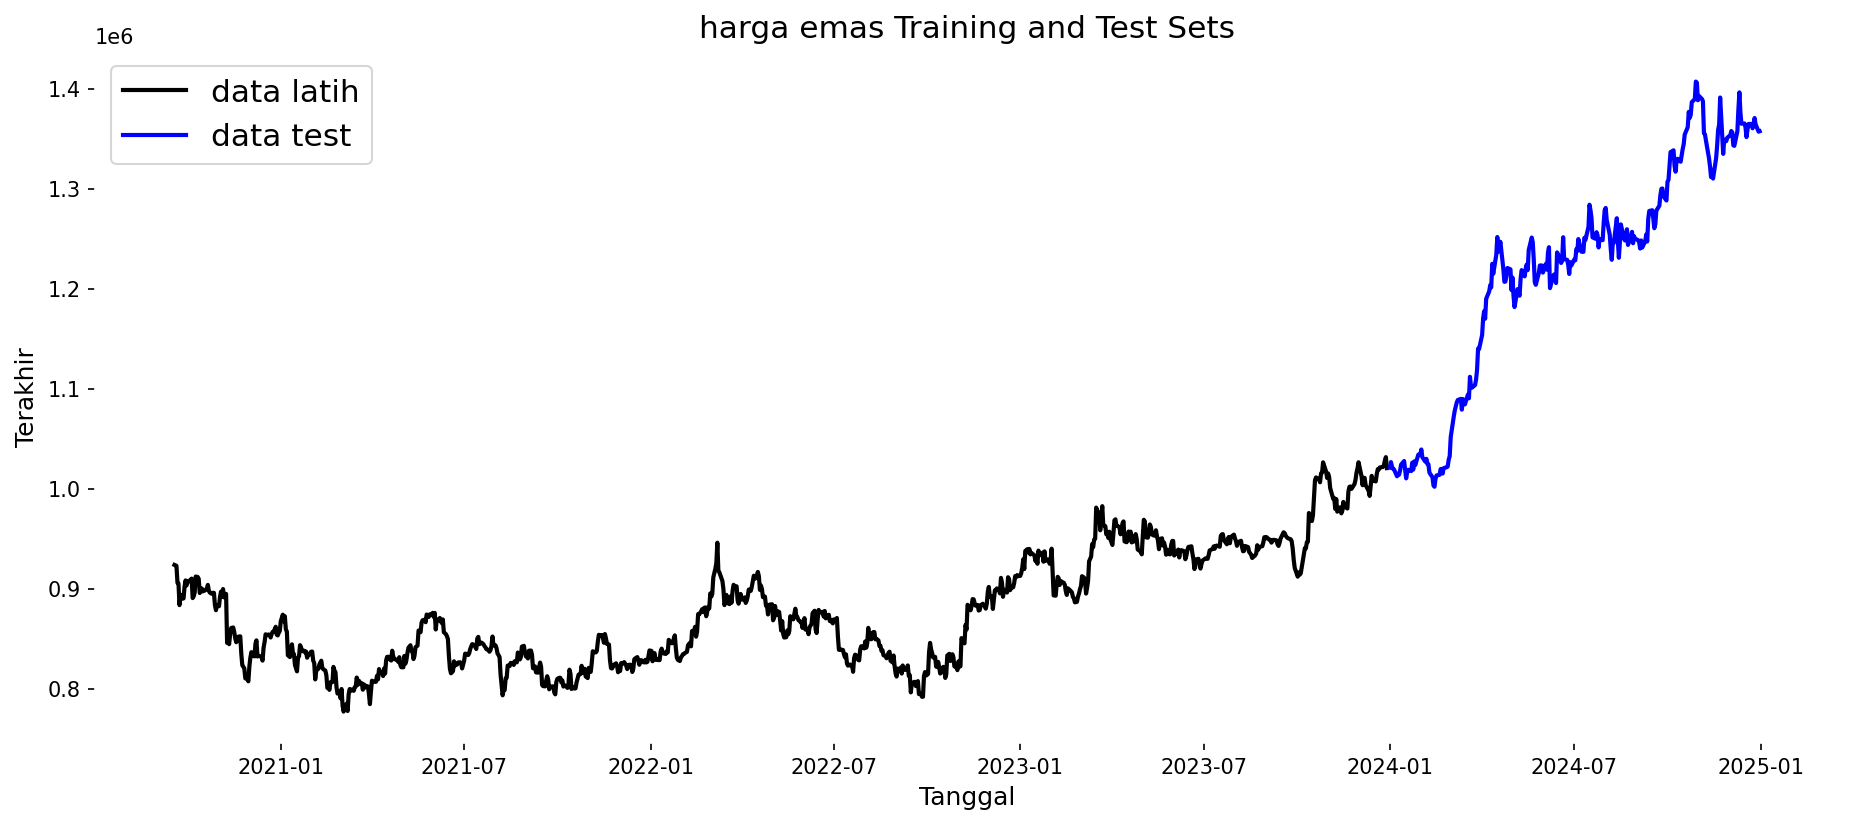

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rc('axes',edgecolor='white')
plt.plot(df.Tanggal[:-test_size], df.Terakhir[:-test_size], color='black', lw=2)
plt.plot(df.Tanggal[-test_size:], df.Terakhir[-test_size:], color='blue', lw=2)
plt.title('harga emas Training and Test Sets', fontsize=15)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Terakhir', fontsize=12)
plt.legend(['data latih', 'data test'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

#6: scaling data

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df.Terakhir.values.reshape(-1,1))

MinMaxScaler()

#7: Restructure Data & Create Sliding Window


The use of prior time steps to predict the next time step is called sliding window. In this way, time series data can be expressed as supervised learning. We can do this by using previous time steps as input variables and use the next time step as the output variable. The number of previous time steps is called the window width. Here we set window width to 60. Therefore, X_train and X_test will be nested lists containing lists of 60 time-stamp prices. y_train and y_test are also lists of gold prices containing the next day's gold price corresponds to each list in X_train and X_test respectively:

In [ ]:
window_size = 90

**Training**

In [ ]:
train_data = df.Terakhir[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [ ]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

**Data Testing**

In [ ]:
test_data = df.Terakhir[-test_size-window_size:] # Ensure enough data for window
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [ ]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0]) # Use window_size, not 60
    y_test.append(test_data[i, 0])

ubah data menjadi numpy

In [ ]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [ ]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (907, 90, 1)
y_train Shape:  (907, 1)
X_test Shape:   (262, 90, 1)
y_test Shape:   (262, 1)


Membuat model

In [ ]:
# def define_model():
#     input1 = Input(shape=(window_size,1))
#     x = LSTM(units = 64, return_sequences=True)(input1)
#     x = Dropout(0.2)(x)
#     x = LSTM(units = 64, return_sequences=True)(x)
#     x = Dropout(0.2)(x)
#     x = LSTM(units = 64)(x)
#     x = Dropout(0.2)(x)
#     x = Dense(32, activation='softmax')(x)
#     dnn_output = Dense(1)(x)

#     model = Model(inputs=input1, outputs=[dnn_output])
#     model.compile(loss='mean_squared_error', optimizer='Nadam')
#     model.summary()

#     return model

def define_model():
    input1 = Input(shape=(window_size, 1))

    x = LSTM(units=64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)

    x = LSTM(units=64, return_sequences=True)(x)
    x = Dropout(0.2)(x)

    x = LSTM(units=64, return_sequences=False)(x)  # Hapus return_sequences=True di LSTM terakhir
    x = Dense(32, activation='relu')(x)  # Ganti softmax jadi ReLU
    x = Dense(16, activation='relu')(x)  # Tambahkan satu layer
    dnn_output = Dense(1)(x)  # Output layer tetap 1 neuron

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='adam')  # Gunakan Adam dulu

    model.summary()

    return model


In [ ]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 90, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 90, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 90, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 90, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 90, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,569 (334.25 KB)

 Trainable params: 85,569 (334.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0093 - val_loss: 0.0054
Epoch 2/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.0711e-04 - val_loss: 0.0024
Epoch 3/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.9456e-04 - val_loss: 0.0015
Epoch 4/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.3107e-04 - val_loss: 0.0015
Epoch 5/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.3423e-04 - val_loss: 0.0020
Epoch 6/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.8169e-04 - val_loss: 0.0015
Epoch 7/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.5976e-04 - val_loss: 0.0013
Epoch 8/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.3815e-04 - val_loss: 0.0013
Epoch 9/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.1442e-04 - val_loss: 0.0012
Epoch 10/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.9556e-04 - val_loss: 0.0012
Epoch 11/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.9305e-04 - val_loss: 0.0010
Epoch 12/150

In [ ]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087     
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [ ]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [ ]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.014196791686117649
Test MAPE: 0.14605539470687504
Test Accuracy: 0.853944605293125


In [ ]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

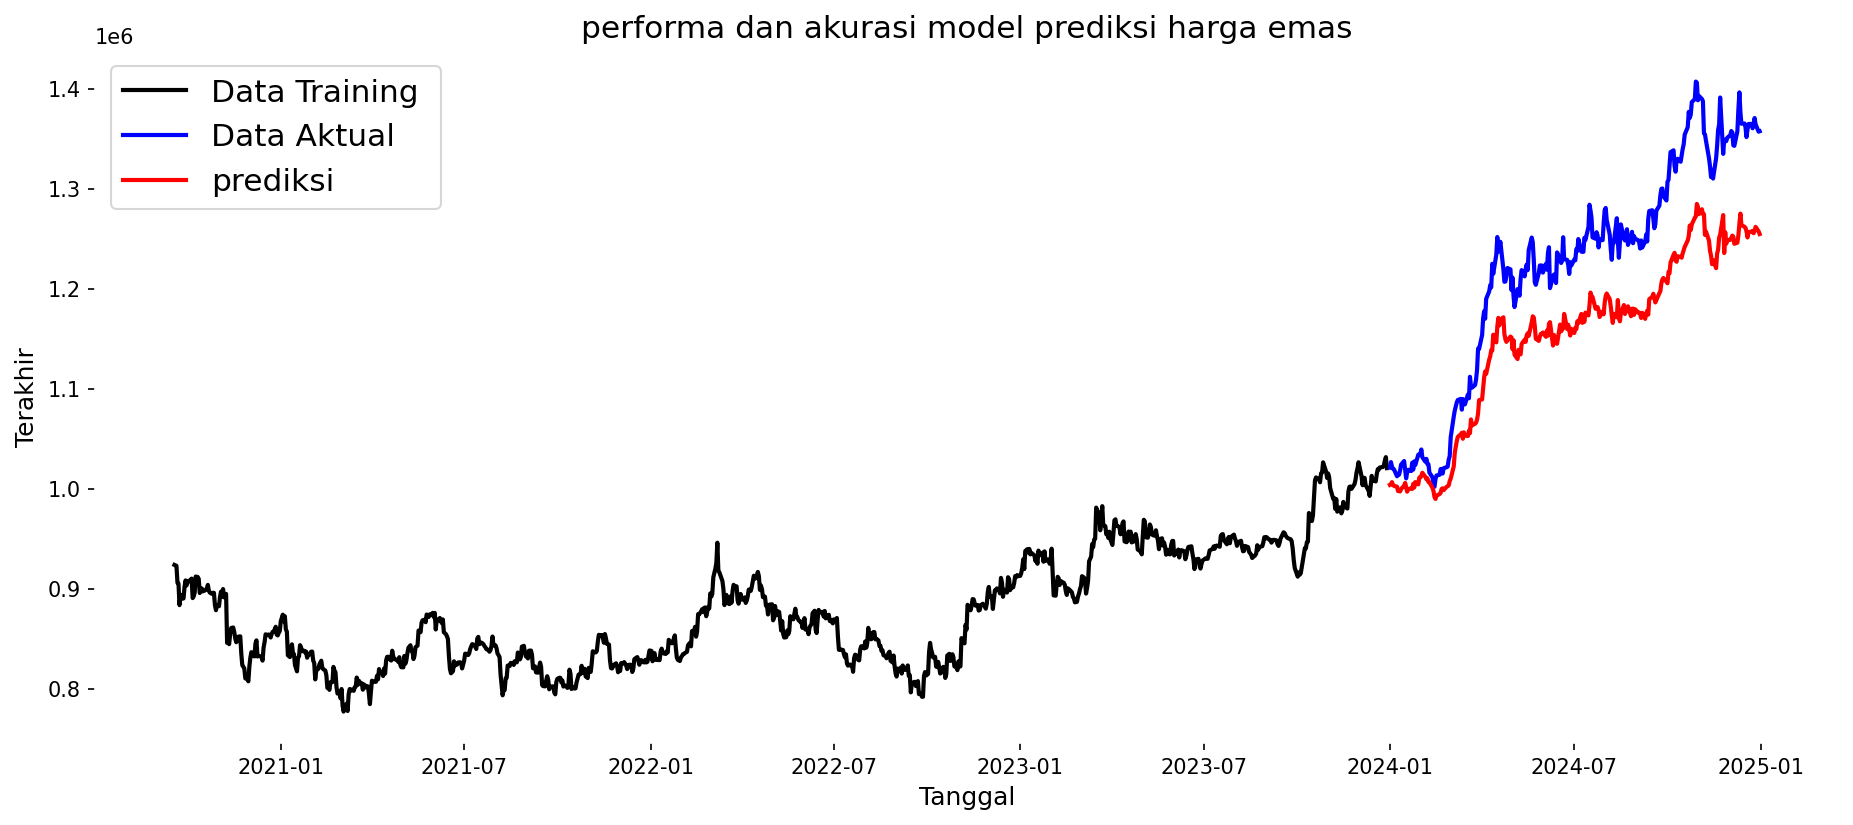

Test Loss: 0.014196791686117649
Test MAPE: 0.14605539470687504
Test Accuracy: 0.853944605293125


In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rc('axes',edgecolor='white')
plt.plot(df['Tanggal'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Tanggal'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Tanggal'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('performa dan akurasi model prediksi harga emas', fontsize=15)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Terakhir', fontsize=12)
plt.legend(['Data Training ', 'Data Aktual', 'prediksi'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)